# Entrenamiento de una GAN en el dataset MNIST

En este tutorial, entrenaremos una Red Generativa Adversaria (GAN) en el conjunto de datos MNIST. Este conjunto de datos consta de una gran colección de imágenes de dígitos escritos a mano de 28x28 píxeles. Intentaremos entrenar una red para generar nuevas imágenes de dígitos escritos a mano.


In [2]:
import deepchem as dc
import tensorflow as tf
from deepchem.models.optimizers import ExponentialDecay
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Reshape
import matplotlib.pyplot as plot
import matplotlib.gridspec as gridspec
%matplotlib inline

#Cargamos el dataset que viene dentro de Tensorflow
mnist = tf.keras.datasets.mnist.load_data(path='mnist.npz')
images = mnist[0][0].reshape((-1, 28, 28, 1))/255
dataset = dc.data.NumpyDataset(images)

11490434/11490434 [==============================] - 7s 1us/step


Imprimamos algunas imagenes para tener una idea de como se ven

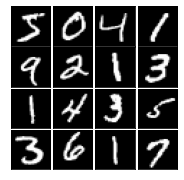

In [3]:
def plot_digits(im):
  plot.figure(figsize=(3, 3))
  grid = gridspec.GridSpec(4, 4, wspace=0.05, hspace=0.05)
  for i, g in enumerate(grid):
    ax = plot.subplot(g)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(im[i,:,:,0], cmap='gray')

plot_digits(images)

Ahora podemos crear nuestra GAN. Al igual que en el último tutorial, consta de dos partes:

1. El generador toma ruido aleatorio como entrada y produce una salida que esperamos que se parezca a los datos de entrenamiento.
2. El discriminador toma un conjunto de muestras como entrada (posiblemente datos de entrenamiento, posiblemente creados por el generador) y trata de determinar cuáles son cuáles.

En este caso, utilizaremos un estilo diferente de GAN llamado Wasserstein GAN (o WGAN). En muchos casos, se ha encontrado que producen mejores resultados que los GAN convencionales. La diferencia principal entre los dos radica en el discriminador (a menudo llamado "crítico" en este contexto). En lugar de producir la probabilidad de que una muestra sea datos de entrenamiento reales, intenta aprender cómo medir la distancia entre la distribución de entrenamiento y la distribución generada. Esa medida se puede utilizar directamente como función de pérdida para entrenar el generador.

Utilizamos un modelo muy sencillo. El generador utiliza una capa densa para transformar el ruido de entrada en una imagen de 7x7 con ocho canales. Le siguen dos capas convolucionales que la aumentan primero a 14x14 y finalmente a 28x28.

El discriminador hace algo similar pero en sentido inverso. Dos capas convolucionales reducen la imagen primero a 14x14 y luego a 7x7. Una capa densa final produce un solo número como salida. En el último tutorial utilizamos una activación sigmoide para producir un número entre 0 y 1 que se podía interpretar como una probabilidad. Dado que se trata de un WGAN, en su lugar utilizamos una activación softplus. Esta produce un número positivo no acotado que se puede interpretar como una distancia.


In [4]:
class DigitGAN(dc.models.WGAN):

    def get_noise_input_shape(self):
        return (10,)

    def get_data_input_shapes(self):
        return [(28, 28, 1)]

    def create_generator(self):
        return tf.keras.Sequential([
            Dense(7*7*8, activation=tf.nn.relu),
            Reshape((7, 7, 8)),
            Conv2DTranspose(filters=16, kernel_size=5, strides=2, activation=tf.nn.relu, padding='same'),
            Conv2DTranspose(filters=1, kernel_size=5, strides=2, activation=tf.sigmoid, padding='same')
        ])

    def create_discriminator(self):
        return tf.keras.Sequential([
            Conv2D(filters=32, kernel_size=5, strides=2, activation=tf.nn.leaky_relu, padding='same'),
            Conv2D(filters=64, kernel_size=5, strides=2, activation=tf.nn.leaky_relu, padding='same'),
            Dense(1, activation=tf.math.softplus)
        ])

gan = DigitGAN(learning_rate=ExponentialDecay(0.001, 0.9, 5000))

Ahora, para entrenarla. Al igual que en el último tutorial, escribimos un generador para producir datos. Esta vez los datos provienen de un conjunto de datos, por lo que iteramos sobre él 100 veces.

Una diferencia que vale la pena destacar es que al entrenar un GAN convencional, es importante mantener el generador y el discriminador en equilibrio durante todo el entrenamiento. Si uno de ellos avanza demasiado, se vuelve muy difícil para el otro aprender.

Los WGANs no tienen este problema. De hecho, cuanto mejor se vuelve el discriminador, más limñio es el señal que proporciona y más fácil se vuelve para el generador aprender. Por lo tanto, especificamos `generator_steps=0.2` para que solo se tome un paso de entrenamiento del generador por cada cinco pasos de entrenamiento del discriminador. Esto tiende a producir un entrenamiento más rápido y mejores resultados.


In [6]:
def iterbatches(epochs):
    for i in range(epochs):
        for batch in dataset.iterbatches(batch_size=gan.batch_size):
            yield {gan.data_inputs[0]: batch[0]}

gan.fit_gan(iterbatches(100), generator_steps=0.2, checkpoint_interval=5000)

KeyboardInterrupt: 

Procedemos a generar datos

In [ ]:
plot_digits(gan.predict_gan_generator(batch_size=16))